In [83]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
#sns.set_style("darkgrid")
sns.set_context("poster")
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np

In [84]:
# Zeroth order reation kinetics: r = k, k = mole/s

# [GSH_0] is the total amount of GSH at time=0
# d[GSH] / dt = [GSH_0] + k/2
# d[GSH+4] / dt = k/2
# d([GSH+4]/([GSH]+[GSH+4])) / dt = (k/2) / ([GSH_0] + k)

# dr/dt = (k/2) / (C + k)
# r(t) = c_1 + (k t)/(2 (C + k))

In [85]:
df = pd.read_csv('cys_label_GSH_time_course_flat3.tab', sep='\t')
df

,Time (h),Species,Experiment,Ratio
0,0.00,GSH,Kinetic tracing,0.001489
1,1.00,GSH,Kinetic tracing,0.070201
2,2.75,GSH,Kinetic tracing,0.170321
3,7.33,GSH,Kinetic tracing,0.324461
4,24.00,GSH,Kinetic tracing,0.451360
5,48.00,GSH,Kinetic tracing,0.468825
6,0.00,GSSG,Kinetic tracing,0.002241
7,1.00,GSSG,Kinetic tracing,0.053930
8,2.75,GSSG,Kinetic tracing,0.145016
9,7.33,GSSG,Kinetic tracing,0.304636


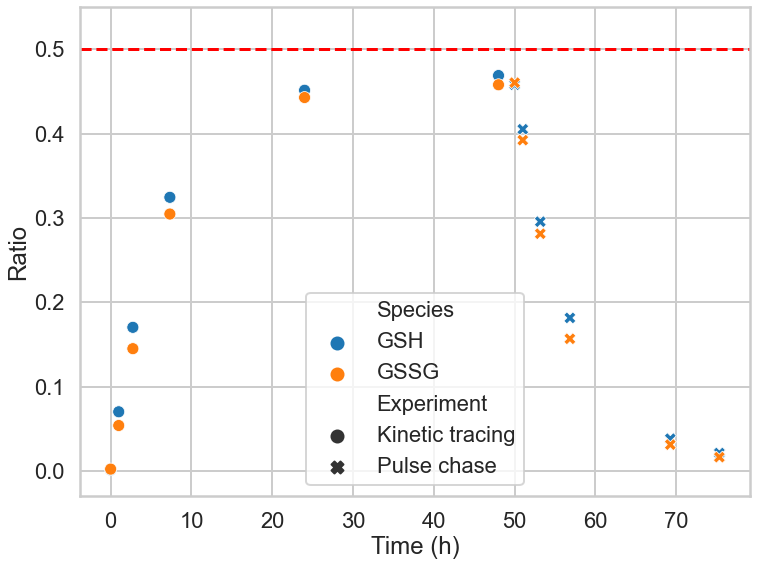

In [86]:
plt.figure(figsize=(12, 9))
ax = sns.scatterplot(x="Time (h)", y="Ratio", hue="Species", style="Experiment", data=df)
ax.set(ylim=(-0.03, 0.55));
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [87]:
def GSH_ratio_formation(t, GSH_0, k, g):
    # GSH_0 = Unlabeled GSH at time=0
    # k = rate of GSH synthesis, labeled and unlabeled
    # g = fraction of labeled Cys (1/2),
    # constrained to be at least 2 since this is what is provided in the media
    return((k*t) / (g*(k*t + GSH_0)))

def GSH_ratio_decay(t, GSH_0, k):
    #print(t)
    # GSH_0 = Ratio of labeled/unlabeled GSH at time=0
    # k = GSH half-life
    return(GSH_0 * (1/2)**(t/k))

In [88]:
def obj_func_formation(p):
    df_formation = df.loc[df['Experiment']=='Kinetic tracing']

    GSH_0, k, g = p
    ss = 0
    for t, r in zip(df_formation['Time (h)'], df_formation['Ratio']):
        if not np.isnan(r):
            ss += (GSH_ratio_formation(t, GSH_0, k, g) - r)**2
    return(ss)

def obj_func_decay(p):
    df_decay = df.loc[df['Experiment']=='Pulse chase']
    k = p[0]
    GSH_0 = np.average(df_decay[df_decay['Time (h)']==50]['Ratio'])
    ss = 0
    for t, r in zip(df_decay['Time (h)'], df_decay['Ratio']):
        if not np.isnan(r):
            ss += (GSH_ratio_decay(t-50, GSH_0, k) - r)**2
    return(ss)

In [89]:
bnds = ((0, None), (0, None), (2, None))
p_formation = minimize(obj_func_formation, (1, 1, 0.05), method='L-BFGS-B', bounds=bnds)

In [90]:
p_formation

      fun: 0.005406663617386376
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.74131543e-06,  8.48548662e-06,  3.08133622e-02])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 44
      nit: 9
   status: 0
  success: True
        x: array([1.63920627, 0.33682556, 2.        ])

In [91]:
# At t=0:
GSH_ratio_formation(0, p_formation.x[0], p_formation.x[1], p_formation.x[2])

0.0

In [92]:
# At t~inf:
GSH_ratio_formation(10000000000, p_formation.x[0], p_formation.x[1], p_formation.x[2])

0.49999999975666837

In [93]:
x_formation = np.linspace(0, 48, 1000)
y_formation = GSH_ratio_formation(x_formation, p_formation.x[0], p_formation.x[1], p_formation.x[2])

In [94]:
bnds = [(0, None)]
p_decay = minimize(obj_func_decay, [1], method='L-BFGS-B', bounds=bnds)
#p_decay = minimize(obj_func_decay, 1, method='L-BFGS-B')

In [95]:
p_decay

      fun: 0.000729430003654792
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.93320056e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 9
   status: 0
  success: True
        x: array([4.82044403])

In [96]:
df_decay = df.loc[df['Experiment']=='Pulse chase']
GSH_0 = np.average(df_decay[df_decay['Time (h)']==50]['Ratio'])
x_decay = np.linspace(50, 50+25.33, 1000)
y_decay = GSH_ratio_decay(x_decay-50, GSH_0, p_decay.x[0])

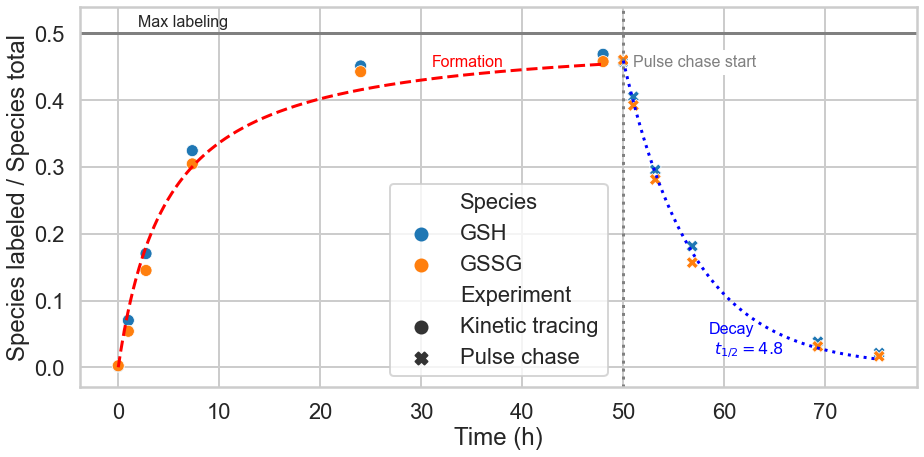

In [103]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(x="Time (h)", y="Ratio", hue="Species", style="Experiment", data=df)
ax.set(ylim=(-0.03, 0.54));
plt.ylabel("Species labeled / Species total")
plt.axhline(y=0.5, color='gray', linestyle='-')
plt.axvline(x=50, color='gray', linestyle=':')
plt.text(51, 0.45, 'Pulse chase start', fontsize=16, color='grey', bbox=dict(facecolor='white', alpha=1))
plt.plot(x_formation, y_formation, color='r', linestyle='--')
plt.plot(x_decay, y_decay, color='b', linestyle=':')
plt.text(2, 0.51, 'Max labeling', fontsize=16)
plt.text(31, 0.45, 'Formation', fontsize=16, color='r')
plt.text(58.5, 0.05, 'Decay', fontsize=16, color='b')
plt.text(59, 0.02, r'$t_{1/2} = 4.8$', fontsize=16, color='b')
#r'$\alpha > \beta$'
plt.show()
fig = ax.get_figure()
fig.savefig('kinetic_label_plot.pdf')

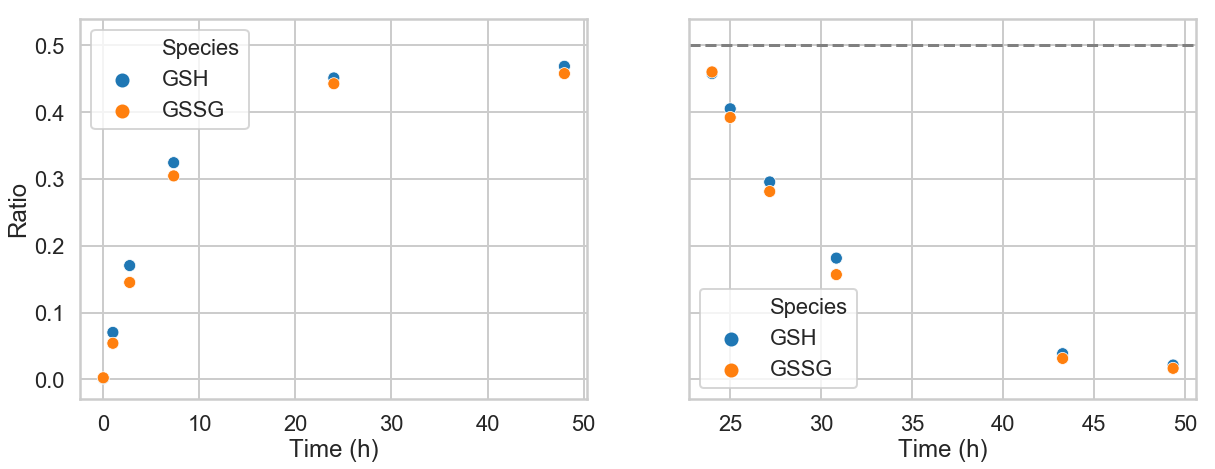

In [150]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 7))
sns.scatterplot(x="Time (h)", y="Ratio", hue="Species", data=df.loc[df['Experiment']=='Kinetic tracing'], ax=ax1)
plt.ylabel("Species labeled / Species total")


sns.scatterplot(x="Time (h)", y="Ratio", hue="Species", data=df.loc[df['Experiment']=='Pulse chase'], ax=ax2)
ax1.set(ylim=(-0.03, 0.54));
plt.axhline(y=0.5, color='gray', linestyle='--')
#plt.axvline(x=24, color='gray', linestyle='--')
#plt.plot(x_formation, y_formation, color='r', linestyle='--')
#plt.plot(x_decay, y_decay, color='r', linestyle='--')
#plt.text(2, 0.51, 'Max labeling', fontsize=16)
#plt.text(31, 0.408, 'Kinetic model', fontsize=16, color='r')
plt.show()
fig = ax.get_figure()
#fig.savefig('kinetic_label_plot.pdf')

In [13]:
df = pd.read_csv('cys_label_BSO_flat.tab', sep='\t')
df

,BSO uM,Species,Ratio
0,0.0,GSH,1.000000
1,0.1,GSH,0.984104
2,1.0,GSH,0.615074
3,10.0,GSH,0.132791
4,50.0,GSH,0.058781
5,150.0,GSH,0.039561
6,0.0,GSSG,1.000000
7,0.1,GSSG,1.261709
8,1.0,GSSG,0.698547
9,10.0,GSSG,0.137780


In [14]:
df.loc[df['BSO uM']>0]

,BSO uM,Species,Ratio
1,0.1,GSH,0.984104
2,1.0,GSH,0.615074
3,10.0,GSH,0.132791
4,50.0,GSH,0.058781
5,150.0,GSH,0.039561
7,0.1,GSSG,1.261709
8,1.0,GSSG,0.698547
9,10.0,GSSG,0.137780
10,50.0,GSSG,0.054852
11,150.0,GSSG,0.032403


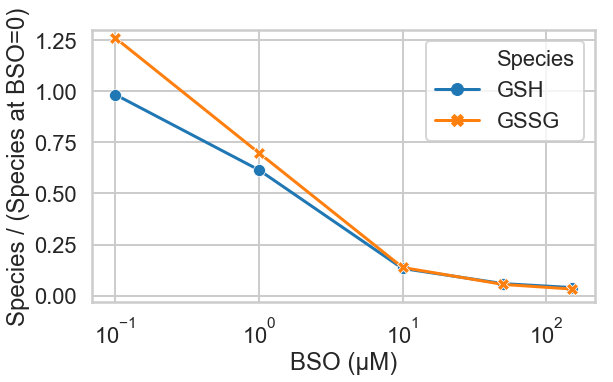

In [15]:
plt.figure(figsize=(9, 5))
ax = sns.lineplot(x="BSO uM", y="Ratio", hue="Species", style="Species", markers=True, dashes=False, estimator=None, data=df.loc[df['BSO uM']>0])
ax.set(xscale="log")
ax.set(ylim=(-0.03, 1.3));
plt.ylabel("Species / (Species at BSO=0)")
plt.xlabel("BSO (µM)")
#plt.axhline(y=0.5, color='gray', linestyle='--')
#plt.plot(x, y, color='r', linestyle='--')
#plt.text(6, 0.51, 'Max labeling', fontsize=16)
#plt.text(31, 0.408, 'Kinetic model', fontsize=16, color='r')
plt.show()
fig = ax.get_figure()
fig.savefig('BSO_plot.pdf')

In [16]:
df = pd.read_csv('auranofin_samples_flat2.tab', sep='\t')
df

,Auro,Cell line,Species,Percent_increase
0,0,143B,GSH,0.000000
1,125,143B,GSH,29.941646
2,250,143B,GSH,46.230823
3,0,786O,GSH,0.000000
4,125,786O,GSH,8.629791
5,250,786O,GSH,55.776657
6,0,UOK262,GSH,0.000000
7,125,UOK262,GSH,24.383176
8,250,UOK262,GSH,32.472340
9,0,143B,GSF/GSH,0.000000


In [17]:
#df_GSH = df.loc[df['Species']=='GSH']
#df_GSH = df_GSH.loc[df['Auro']>0]
#df_GSH.loc[:, 'Ratio'] = df_GSH.loc[:, 'Ratio']*100 - 100

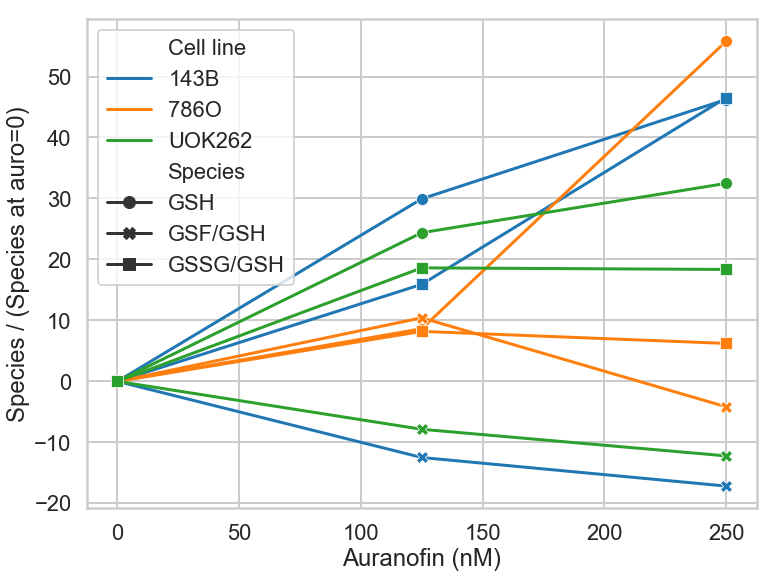

In [18]:
#plt.figure(figsize=(9, 5))

plt.figure(figsize=(12, 9))
ax = sns.lineplot(x="Auro", y="Percent_increase", hue="Cell line", style="Species", markers=True, dashes=False, estimator=None, data=df)
#ax = sns.barplot(x="Auro", y="Ratio", hue="Cell line", errcolor=".2", edgecolor=".2", data=df_GSH)
#ax.set(ylim=(-0.03, 1.3));
plt.ylabel("Species / (Species at auro=0)")
plt.xlabel("Auranofin (nM)")
#plt.axhline(y=0.5, color='gray', linestyle='--')
#plt.plot(x, y, color='r', linestyle='--')
#plt.text(6, 0.51, 'Max labeling', fontsize=16)
#plt.text(31, 0.408, 'Kinetic model', fontsize=16, color='r')
plt.show()
#fig = ax.get_figure()
#fig.savefig('kinetic_label_plot.pdf')

<Figure size 648x360 with 0 Axes>

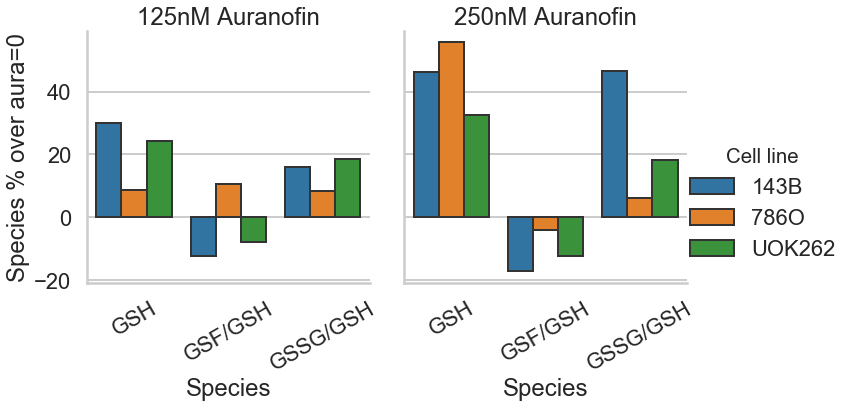

In [19]:
plt.figure(figsize=(9, 5))
#plt.figure(figsize=(24, 9))

ax = sns.catplot(x="Species", y="Percent_increase", hue="Cell line", col="Auro", data=df.loc[df['Auro']>0], kind="bar", errcolor=".2", edgecolor=".2");

ax.set_xticklabels(rotation=30)
ax.set_titles("{col_name}nM Auranofin")

#ax.set(ylim=(-0.03, 1.3));
#plt.ylabel("Species % over aura=0")
ax.set_axis_labels("Species", "Species % over aura=0")
#plt.ylabel("Species / (Species at auro=0)")
#plt.xlabel("Auranofin (µM)")
#plt.axhline(y=0.5, color='gray', linestyle='--')
#plt.plot(x, y, color='r', linestyle='--')
#plt.text(6, 0.51, 'Max labeling', fontsize=16)
#plt.text(31, 0.408, 'Kinetic model', fontsize=16, color='r')
plt.show()
#fig = ax.get_figure()
ax.savefig('aura_plot2.pdf')

In [20]:
plt.figure(figsize=(12, 9))
ax = sns.barplot(x="Auro", y="Ratio", hue="Cell line", errcolor=".2", edgecolor=".2", data=df.loc[df['Auro']>0])
ax.set(ylim=(0.9, 1.85));
plt.ylabel("(GSH+GSSG) / (GSH+GSSG at aura=0)")
plt.xlabel("Auranofin (nM)")
plt.axhline(y=1, color='r', linestyle='--')
plt.text(1.52, 0.994, 'Aura=0', fontsize=16)
plt.show()
#fig = ax.get_figure()
#fig.savefig('kinetic_label_plot.pdf')

ValueError: Could not interpret input 'Ratio'

<Figure size 864x648 with 0 Axes>

In [ ]:
df_percent = df.loc[df['Auro']>0]
df_percent.loc[:, 'Ratio'] = df_percent.loc[:, 'Ratio']*100 - 100

In [ ]:
plt.figure(figsize=(9, 5))
ax = sns.barplot(x="Auro", y="Ratio", hue="Cell line", errcolor=".2", edgecolor=".2", data=df_percent)
#ax.set(ylim=(0.9, 1.85));
plt.ylabel("(GSH+GSSG) % over aura=0")
plt.xlabel("Auranofin (nM)")
plt.show()
fig = ax.get_figure()
fig.savefig('aura_plot.pdf')